In [2]:
import jax
import jax.numpy as jnp
import specq_jax as sqj
import specq_dev as sqd
import numpyro
from numpyro.contrib.module import random_flax_module
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, TraceMeanField_ELBO, autoguide, init_to_feasible
from functools import partial
import optax
from pathlib import Path

2024-10-10 11:51:38,570	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-10 11:51:38,804	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
# https://arxiv.org/abs/1505.05424

## Generate some data

In [5]:
key = jax.random.PRNGKey(0)
key, pulse_key, transformer_key, train_key, model_key = jax.random.split(key, 5)
config, pulse_sequence, pulse_parameters, unitaries, hamiltonian = (
    sqj.utils.testing.gen_mock_data(key=pulse_key, batch_size=int(1500))
)

# Generate noisy expectation values
# Wo_params, noise_transfomer = sqj.utils.testing.gen_Wo_params_v2(
#     transformer_key, pulse_sequence, pulse_parameters
# )

# expvals = sqj.core.get_predict_expectation_value(
#     Wos_params=Wo_params,
#     unitaries=unitaries[:, -1, :, :],
#     evaluate_expectation_values=sqd.shared.default_expectation_values,
# )

# Generate noiseless expectation values
# Calculate the expectation values with shot estimation.
expvals = []
final_unitaries = unitaries[:, -1, :, :]

plus_projectors = {
    "X": sqd.shared.State.from_label("+", dm=True),
    "Y": sqd.shared.State.from_label("r", dm=True),
    "Z": sqd.shared.State.from_label("0", dm=True),
}

for exp in sqd.shared.default_expectation_values:

    key, sample_key = jax.random.split(key)
    sample_keys = jax.random.split(sample_key, num=final_unitaries.shape[0])

    # expval = jax.vmap(calculate_shots_expectation_value, in_axes=(0, None, 0, None, None))(
    #     sample_keys, exp.get_density_matrix(), final_unitaries, plus_projectors[exp.observable], SHOTS
    # )

    expval = jax.vmap(sqj.core.calculate_exp, in_axes=(0, None, None))(final_unitaries, exp.get_operator(), exp.get_state())

    expvals.append(expval)

expvals = jnp.array(expvals)

unitaries = unitaries[:, -1, :, :]

## Load data

In [92]:
path = Path("0022")
exp_data, pulse_parameters, unitaries, expectations, pulse_sequence, simulator = (
    sqj.data.load_data(path)
)

pulse_parameters = jnp.array(pulse_parameters)
expvals = jnp.array(expectations.T)
unitaries = jnp.array(unitaries)

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)


In [4]:
def BNNModel(x, y=None, batch_size=None):
    base_module = sqj.model.BasicBlackBox(
        **{"feature_size": 9, "hidden_sizes_1": [29, 13], "hidden_sizes_2": [46, 32]}
    )
    net = random_flax_module(
        "nn",
        base_module,
        dist.Normal(0, 1.0),
        input_shape=(batch_size, pulse_parameters.shape[1]),
        training=False,
    )

    with numpyro.plate("batch", x.shape[0], subsample_size=batch_size, dim=-1) as ind:

        batch_x = x[ind]
        batch_y = y[ind] if y is not None else None

        pred = net(batch_x, training=True)

        predict_expvals = sqj.core.get_predict_expectation_value(
            Wos_params=pred,
            unitaries=unitaries[ind],
            evaluate_expectation_values=sqd.shared.default_expectation_values,
        )

        for idx, exp in enumerate(sqd.shared.default_expectation_values):
            numpyro.sample(
                f"obs_{idx}",
                # dist.Normal(predict_expvals[idx], jnp.ones_like(predict_expvals[idx]) * 0.05),
                # dist.Beta(predict_expvals[idx], 1.0),
                dist.TruncatedNormal(predict_expvals[idx], 0.05, low=-1.0, high=1.0),
                obs=batch_y.T[idx] if batch_y is not None else None,
            )

In [7]:
n_iterations = 10_000

lr_schedule = optax.warmup_cosine_decay_schedule(
    init_value=1e-6,
    peak_value=1e-2,
    warmup_steps=1000,
    decay_steps=10000,
    end_value=1e-6,
)

optimiser = optax.adamw(learning_rate=lr_schedule)
# Automatic Guide Generation for Stan via NumPyro :  https://arxiv.org/abs/2110.11790
guide = autoguide.AutoDiagonalNormal(BNNModel, init_loc_fn=init_to_feasible)
svi = SVI(
    BNNModel,
    guide,
    numpyro.optim.optax_to_numpyro(optimiser),
    TraceMeanField_ELBO(),
)

svi_result = svi.run(
    jax.random.PRNGKey(0),
    n_iterations,
    x=jnp.array(pulse_parameters),
    y=expvals.T, 
    # y=jnp.array(expectations),
    batch_size=100,
)

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
100%|██████████| 10000/10000 [01:11<00:00, 140.54it/s, init loss: 1718411.8273, avg. loss [9501-10000]: -54883.3656]


In [ ]:
pulse_parameters[:100].shape

In [1]:
params, losses = svi_result.params, svi_result.losses
predictive = Predictive(BNNModel, guide=guide, params=params, num_samples=1000)

y_pred = predictive(jax.random.PRNGKey(1), pulse_parameters[:100])

recovered_y = []
std = []
for idx, exp in enumerate(sqd.shared.default_expectation_values):
    recovered_y.append(y_pred[f"obs_{idx}"].mean(axis=0))
    std.append(y_pred[f"obs_{idx}"].std(axis=0))

recovered_y = jnp.array(recovered_y).T
std = jnp.array(std).T

NameError: name 'svi_result' is not defined

In [ ]:
asf

In [12]:
posterior_samples = guide.sample_posterior(jax.random.PRNGKey(1), params, sample_shape=(10000,))

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

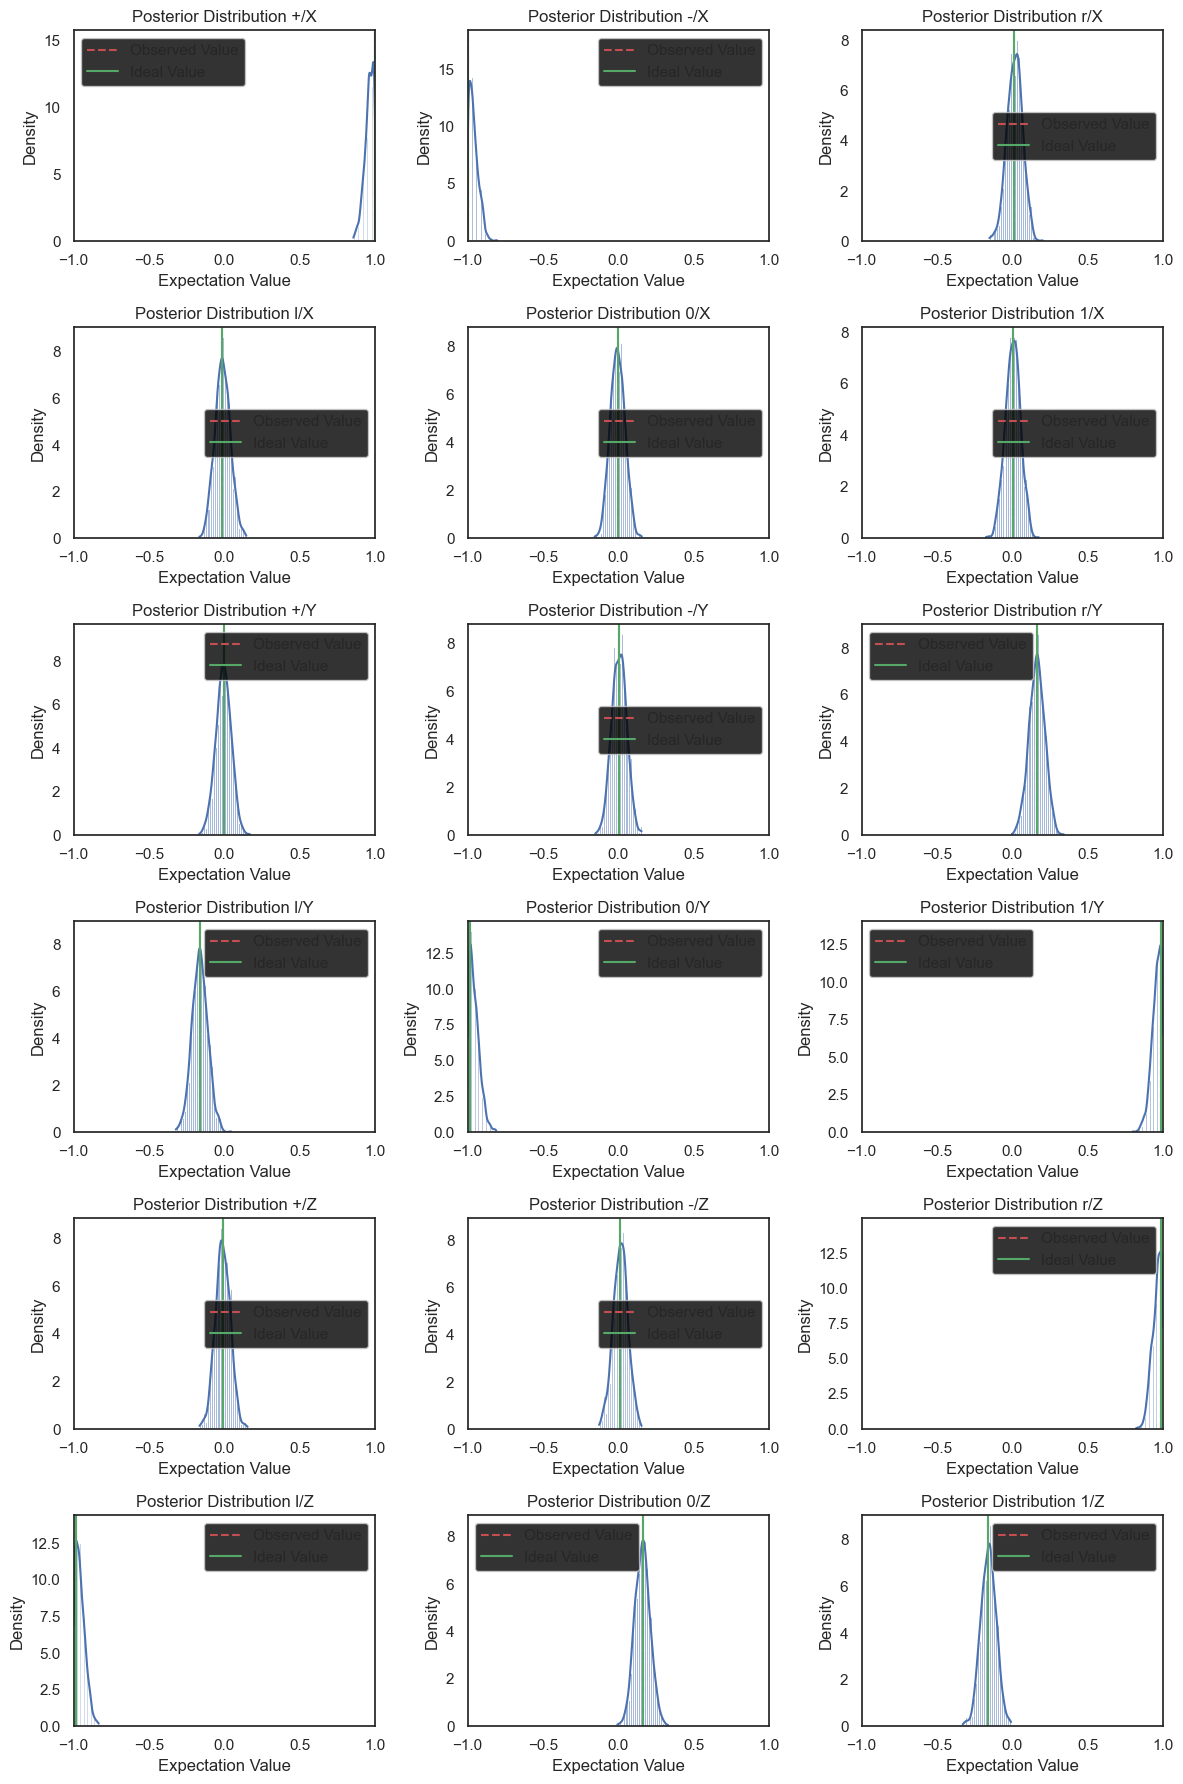

In [90]:
# Sample index to plot for
sample_idx = 60
num_exps = len(sqd.shared.default_expectation_values) # Number of expectation values

# Create a figure with a 3x6 grid of subplots
fig, axes = plt.subplots(6, 3, figsize=(12, 18))
# fig, axes = plt.subplots(3, 6, figsize=(18, 12))

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

for idx, exp in enumerate(sqd.shared.default_expectation_values):
    # Calculate the ideal expectation value with given unitary and current expectation operator
    ideal_exp = sqj.core.calculate_exp(
        unitary=unitaries[sample_idx], 
        operator=exp.get_operator(), 
        initial_state=exp.get_state()
    )

    # Select the subplot
    ax = axes[idx]

    # Plot the histogram of the predictions
    sns.histplot(y_pred[f"obs_{idx}"].T[sample_idx], kde=True, stat="density", ax=ax)

    # Plot vertical lines for the observed and ideal expectation values
    ax.axvline(expvals.T[sample_idx][idx], 0, 1, color="r", linestyle="--", label="Observed Value")
    ax.axvline(ideal_exp, 0, 1, color="g", linestyle="-", label="Ideal Value")
    
    # Set x-axis limits
    ax.set_xlim(-1, 1)
    
    # Add title and labels
    ax.set_title(f'Posterior Distribution {exp.initial_state}/{exp.observable}')
    ax.set_xlabel('Expectation Value')
    ax.set_ylabel('Density')
    ax.legend()

# Hide empty subplots if there are fewer than 18 expectation values
for i in range(num_exps, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axe

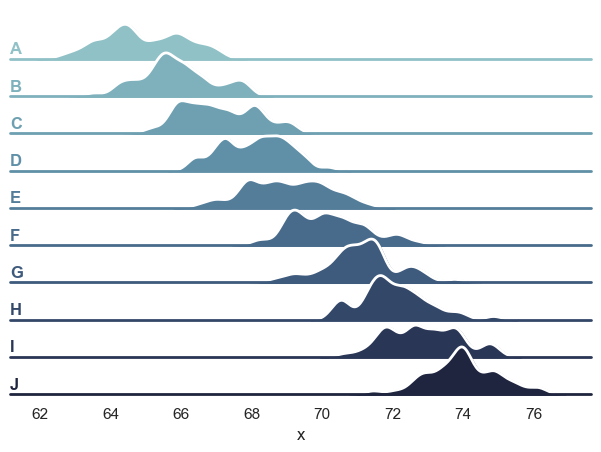

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [50]:
df

,x,g
0,64.038123,A
1,66.147050,B
2,66.370011,C
3,68.791019,D
4,70.583534,E
...,...,...
495,69.358022,F
496,72.212877,G
497,70.474247,H
498,73.251022,I


In [72]:
named_expvals = {
    f'{exp.initial_state}/{exp.observable}': y_pred[f"obs_{idx}"]
for idx, exp in enumerate(sqd.shared.default_expectation_values)}

In [73]:
named_expvals['+/X'].shape

(1000, 100)

In [74]:
# Pandas DataFrame with sample_id, expectation value, realization_id and state/observable as columns
# The keys of named_expvals are the state/observable names and the values in the shape of (realization_id, sample_id)
rows = []
for idx, exp in enumerate(sqd.shared.default_expectation_values):
    for realization_id, realization in enumerate(named_expvals[f'{exp.initial_state}/{exp.observable}']):
        for sample_id, sample in enumerate(realization):
            # print(sample_id, sample, realization_id, exp.initial_state, exp.observable)
            temp_dict = {
                'sample_id': sample_id,
                'expectation_value': float(sample),
                # 'realization_id': realization_id,
                'state_observable': f'{exp.initial_state}/{exp.observable}'
            }
            rows.append(temp_dict)

In [75]:
dataframe = pd.DataFrame(rows)
dataframe

,sample_id,expectation_value,state_observable
0,0,0.956787,+/X
1,1,0.975103,+/X
2,2,0.934363,+/X
3,3,0.996454,+/X
4,4,0.873109,+/X
...,...,...,...
1799995,95,-0.951841,1/Z
1799996,96,-0.093020,1/Z
1799997,97,-0.587242,1/Z
1799998,98,0.320222,1/Z


/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/porametpathumsoot/miniconda3/envs/specq-jax/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


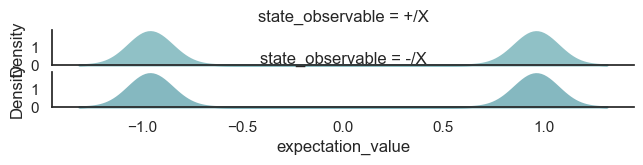

In [83]:
selected_id = 12
sub_df = dataframe[dataframe['sample_id'] == selected_id]
# Select only '+/X' and '-/X' states
sub_df = sub_df[sub_df['state_observable'].isin(['+/X', '-/X'])]
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(18, rot=-.25, light=.7)
g = sns.FacetGrid(sub_df, row="state_observable", hue="state_observable", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, x="expectation_value", data=sub_df,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, "expectation_value", clip_on=False, color="w", lw=2, bw_adjust=.5)

<Axes: xlabel='expectation_value', ylabel='Density'>

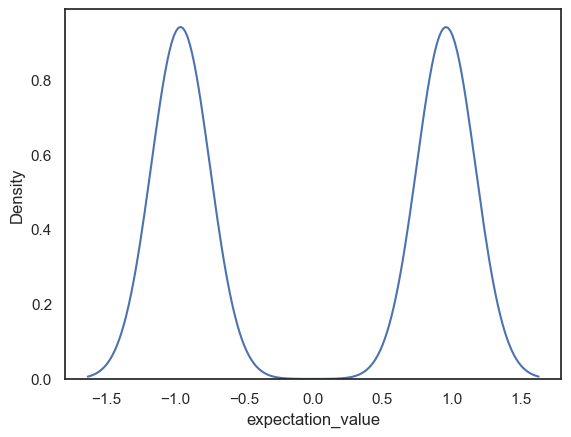

In [80]:
sns.kdeplot(data=sub_df, x="expectation_value")

<Axes: xlabel='expectation_value', ylabel='Density'>

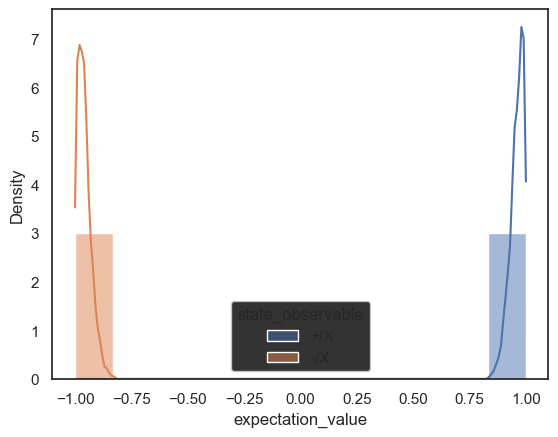

In [87]:
sns.histplot(data=sub_df, x="expectation_value", hue='state_observable', kde=True, stat="density")